# Flight Price Prediction

In [11]:
!pip install ydata-profiling

In [12]:
# Import necessary libraries

import pandas as pd # for data manipulation and analysis
import numpy as np # for fast mathematical operations
import matplotlib.pyplot as plt # for visualization and plots
import seaborn as sns # for statistical data visualization
from scipy import stats # for statistical analysis
from ydata_profiling import ProfileReport # for exploratory data analysis

from sklearn.model_selection import train_test_split # for splitting dataset into training and testing subsets
from sklearn.preprocessing import LabelEncoder # to convert categorical data (text labels) into numeric form

from sklearn.ensemble import RandomForestRegressor # for Random Forest Regression model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # for model evaluation

from sklearn.model_selection import learning_curve # for learning curves plot

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## Dataset Description

**Source:** Kaggle  
**Dataset Name:** Flight Price Prediction  
**URL:** https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

This dataset contains information about flight booking options from the website "Ease My Trip" for travel between India's top 6 metro cities.

It includes features such as airline, flight code, source and destination cities, departure and arrival times, number of stops, class, duration, and ticket price.

### Load the dataset

Download the dataset from https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

The dataset will contain 2 files: business.csv, economy.csv and Clean_Dataset.csv

Upload these files to the same directory as this notebook (root dir on collab files).

In [13]:
# Load and inspect all dataset files

import pandas as pd
import numpy as np

print("Loading datasets...")
print("\n" + "="*80)

business_dataset_filename = 'business.csv'
economy_dataset_filename = 'economy.csv'
clean_dataset_filename = 'Clean_Dataset.csv'

try:
    business_df = pd.read_csv(business_dataset_filename)
    print(f"{business_dataset_filename} is loaded: {business_df.shape[0]} rows, {business_df.shape[1]} columns")
    print(f"Sample data:")
    display(business_df.head(3))
    print("\n")
except FileNotFoundError:
    print(f"{business_dataset_filename} not found")
    raise

try:
    economy_df = pd.read_csv(economy_dataset_filename)
    print(f"{economy_dataset_filename} is loaded: {economy_df.shape[0]} rows, {economy_df.shape[1]} columns")
    print(f"Sample data:")
    display(economy_df.head(3))
    print("\n")
except FileNotFoundError:
    print(f"{economy_dataset_filename} not found")
    raise

try:
    clean_df = pd.read_csv(clean_dataset_filename)
    df = clean_df
    print(f"{clean_dataset_filename} is loaded: {clean_df.shape[0]} rows, {clean_df.shape[1]} columns")
    print(f"Sample data:")
    display(clean_df.head(3))
    print("\n")
except FileNotFoundError:
    print(f"{clean_dataset_filename} not found")
    raise

print("\n" + "="*80)
print(f"Total rows in {business_dataset_filename} and {economy_dataset_filename} combined:",
      business_df.shape[0] + economy_df.shape[0])
print(f"vs. rows in {clean_dataset_filename}: {clean_df.shape[0]}")

Loading datasets...

business.csv is loaded: 93487 rows, 11 columns
Sample data:


date    airline ch_code  num_code dep_time   from time_taken  \
0  11-02-2022  Air India      AI       868    18:00  Delhi    02h 00m   
1  11-02-2022  Air India      AI       624    19:00  Delhi    02h 15m   
2  11-02-2022  Air India      AI       531    20:00  Delhi    24h 45m   

                                                stop arr_time      to   price  
0                                          non-stop     20:00  Mumbai  25,612  
1                                          non-stop     21:15  Mumbai  25,612  
2  1-stop\r\n\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t...    20:45  Mumbai  42,220



economy.csv is loaded: 206774 rows, 11 columns
Sample data:


date   airline ch_code  num_code dep_time   from time_taken  \
0  11-02-2022  SpiceJet      SG      8709    18:55  Delhi    02h 10m   
1  11-02-2022  SpiceJet      SG      8157    06:20  Delhi    02h 20m   
2  11-02-2022   AirAsia      I5       764    04:25  Delhi    02h 10m   

        stop arr_time      to  price  
0  non-stop     21:05  Mumbai  5,953  
1  non-stop     08:40  Mumbai  5,953  
2  non-stop     06:35  Mumbai  5,956



Clean_Dataset.csv is loaded: 300153 rows, 12 columns
Sample data:


Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956




Total rows in business.csv and economy.csv combined: 300261
vs. rows in Clean_Dataset.csv: 300153


The original includes has 3 CSV files:

1. business.csv: 93487 rows, 11 columns
   - Contains only business class flights
   - Represents ~31% of total data
   - Higher prices expected

2. economy.csv: 206774 rows, 11 columns  
   - Contains only ECONOMY class flights
   - Represents ~69% of total data
   - Lower prices expected
   - More than 2 times the business data (imbalanced)

3. Clean_Dataset.csv: 300153 rows, 12 columns
   - Combined dataset (business + economy data merged)
   - Excluded 108 rows from initial data (300261 raw dataset vs. 300153 raws in clean dataset)
   - This is a cleaned version, not just a simple merge
   - Has one extra column (12 vs. 11) - "Unnamed" column plays role of ID

In the next sections I will only inspect cleaned dataset (Clean_Dataset.csv).

### Dataset Structure and Attributes

In [14]:
# Display dataset data types and info

print("Dataset Information:")
print("="*80)

clean_df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [15]:
# summary DataFrame
attribute_summary = pd.DataFrame({
    'Attribute': clean_df.columns,
    'Data Type': clean_df.dtypes.values,
    'Count': clean_df.count().values,
    'Null Count': clean_df.isnull().sum().values,
    'Unique Values': [clean_df[col].nunique() for col in clean_df.columns],
    'Min':  [clean_df[col].min() if clean_df[col].dtype in ['int64', 'float64'] else '-'
            for col in clean_df.columns],
    'Max':  [clean_df[col].max() if clean_df[col].dtype in ['int64', 'float64'] else '-'
            for col in clean_df. columns]
})

print("\n" + "="*80)
print("Attribute Summary")
print("="*80)
attribute_summary


Attribute Summary


Attribute Data Type   Count  Null Count  Unique Values   Min  \
0         Unnamed: 0     int64  300153           0         300153     0   
1            airline    object  300153           0              6     -   
2             flight    object  300153           0           1561     -   
3        source_city    object  300153           0              6     -   
4     departure_time    object  300153           0              6     -   
5              stops    object  300153           0              3     -   
6       arrival_time    object  300153           0              6     -   
7   destination_city    object  300153           0              6     -   
8              class    object  300153           0              2     -   
9           duration   float64  300153           0            476  0.83   
10         days_left     int64  300153           0             49     1   
11             price     int64  300153           0          12157  1105   

       Max  
0   300152  
1        -  
2        -  
3        -  
4        -  
5        -  
6        -  
7        -  
8        -  
9    49.83  
10      49  
11  123071

In [16]:

# Display unique values

print("\nUnique values in airline column")
print(clean_df['airline'].unique())

print("\nUnique values in source_city column")
print(clean_df['source_city'].unique())

print("\nUnique values in departure_time column")
print(clean_df['departure_time'].unique())

print("\nUnique values in stops column")
print(clean_df['stops'].unique())

print("\nUnique values in arrival_time column")
print(clean_df['arrival_time'].unique())

print("\nUnique values in destination_city column")
print(clean_df['destination_city'].unique())

print("\nUnique values in class column")
print(clean_df['class'].unique())

print("\nUnique values in days_left column")
print(clean_df['days_left'].unique())


Unique values in airline column
['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']

Unique values in source_city column
['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']

Unique values in departure_time column
['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']

Unique values in stops column
['zero' 'one' 'two_or_more']

Unique values in arrival_time column
['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']

Unique values in destination_city column
['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']

Unique values in class column
['Economy' 'Business']

Unique values in days_left column
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


Attribute categories in dataset:
- `Unnamed: 0` - Index column
- `airline` - Airline company name (6 unique airlines)
- `flight` - Flight code/number (1561 unique flights)
- `source_city` - Departure city (6 unique cities)
- `departure_time` - Time of day category for departure (string, 6 time slots)
- `stops` - Number of stops: zero, one, or two_or_more (3 categories)
- `arrival_time` - Time of day category for arrival (dtring, 6 time slots)
- `destination_city` - Arrival city (6 unique cities)
- `class` - Flight class:  Business or Economy (2 categories)  
- `duration` - Flight duration in hours (float, 476 unique values)
- `days_left` - Days remaining until departure (integer in range 1-49)
- `price` - Flight ticket price (integer, in indian currency - indian rupee, INR, रू)


## Exploratory Data Analysis


In [17]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if 'Unnamed' not in col]

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [18]:
# Descriptive statistics for numerical features

print("Descriptive statistics for numerical features")
print("="*80)
clean_df.describe().T

Descriptive statistics for numerical features


count      mean      std     min      25%       50%       75%  \
Unnamed: 0 300153.00 150076.00 86646.85    0.00 75038.00 150076.00 225114.00   
duration   300153.00     12.22     7.19    0.83     6.83     11.25     16.17   
days_left  300153.00     26.00    13.56    1.00    15.00     26.00     38.00   
price      300153.00  20889.66 22697.77 1105.00  4783.00   7425.00  42521.00   

                 max  
Unnamed: 0 300152.00  
duration       49.83  
days_left      49.00  
price      123071.00

In [19]:
# Categorical features summary

print("Categorical features summary")
print("="*80)

for col in categorical_cols:
    print(f"\nColumn {col}:")
    print(f"\tUnique values: {clean_df[col]. nunique()}")
    print(f"\tMost common:  {clean_df[col].mode()[0]} (appears {clean_df[col].value_counts().iloc[0]} times)")
    print(f"\tValue counts:")
    print(clean_df[col].value_counts().head(10))
    print("-"*80)

Categorical features summary

Column airline:
	Unique values: 6
	Most common:  Vistara (appears 127859 times)
	Value counts:
airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64
--------------------------------------------------------------------------------

Column flight:
	Unique values: 1561
	Most common:  UK-706 (appears 3235 times)
	Value counts:
flight
UK-706    3235
UK-772    2741
UK-720    2650
UK-836    2542
UK-822    2468
UK-828    2440
UK-874    2423
UK-832    2404
UK-826    2335
UK-860    2329
Name: count, dtype: int64
--------------------------------------------------------------------------------

Column source_city:
	Unique values: 6
	Most common:  Delhi (appears 61343 times)
	Value counts:
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64
--------------------------------

In [20]:
# Price distribution analysis

print("Price distribution analysis")
print("="*80)

# Mean = the sum of all values divided by the number of values.
print(f"Mean price: {clean_df['price'].mean():,.2f}")

# Meadian = the middle value when data is sorted.
print(f"Median price: {clean_df['price'].median():,.2f}")

# Standard deviation is a statistical measure that tells you how spread out
# the values in a dataset are around the average (mean).
print(f"Standard deviation: {clean_df['price'].std():,.2f}")

print(f"Min price: {clean_df['price'].min():,.2f}")
print(f"Max price: {clean_df['price'].max():,.2f}")
print(f"Range: {clean_df['price'].max() - clean_df['price'].min():,.2f}")

Price distribution analysis
Mean price: 20,889.66
Median price: 7,425.00
Standard deviation: 22,697.77
Min price: 1,105.00
Max price: 123,071.00
Range: 121,966.00


### Data Visualization

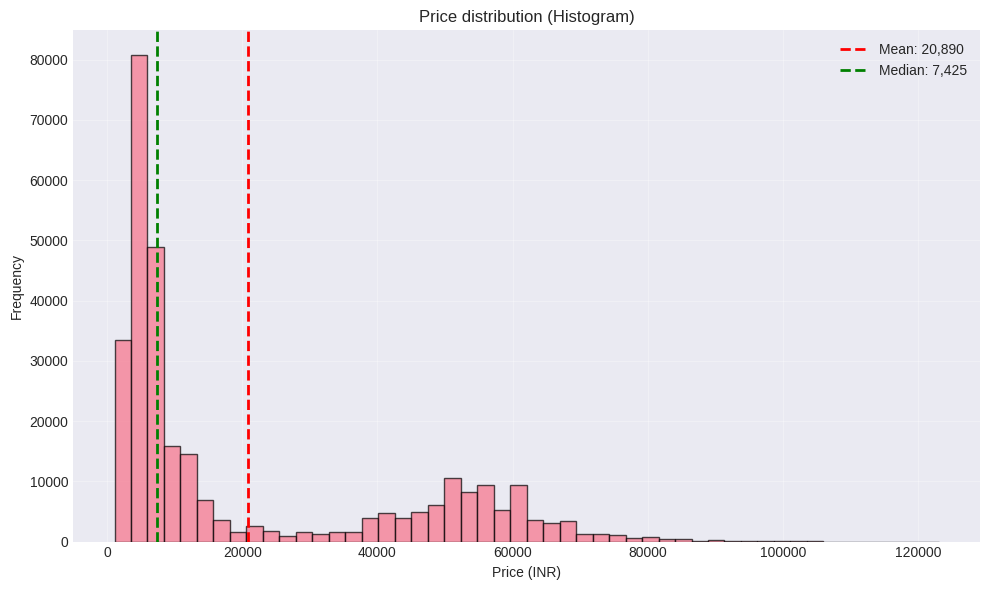

In [21]:
# Price distribution visualization

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(clean_df['price'], bins=50, edgecolor='black', alpha=0.7)
# Mean is red
ax.axvline(clean_df['price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {clean_df["price"].mean():,.0f}')
# Median is green
ax.axvline(clean_df['price'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {clean_df["price"].median():,.0f}')
ax.set_xlabel('Price (INR)')
ax.set_ylabel('Frequency')
ax.set_title('Price distribution (Histogram)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

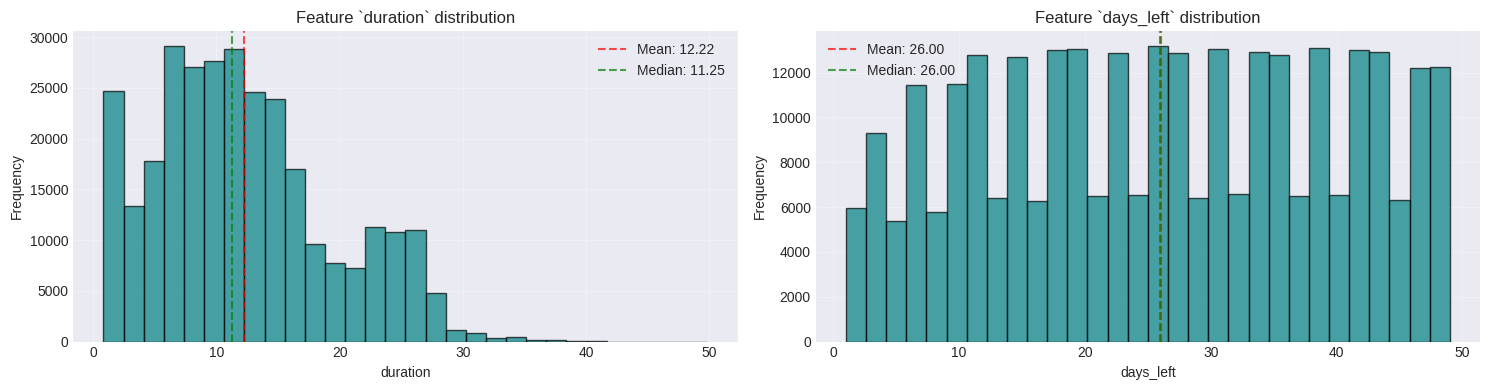

In [22]:
# Numerical features visualization (excluding price and unnamed)

numerical_cols = clean_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_features = [col for col in numerical_cols if col != 'price' and 'Unnamed' not in col]

n_num = len(num_features)
n_rows = (n_num + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_num > 1 else [axes]

for idx, col in enumerate(num_features):
    axes[idx].hist(clean_df[col]. dropna(), bins=30, edgecolor='black', alpha=0.7, color='teal')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Feature `{col}` distribution')
    axes[idx].grid(True, alpha=0.3)

    # Add statistics
    mean_val = clean_df[col].mean()
    median_val = clean_df[col].median()
    # Mean is red
    axes[idx].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    # Median is green
    axes[idx].axvline(median_val, color='green', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
    axes[idx].legend()

# Remove empty subplots
for idx in range(n_num, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

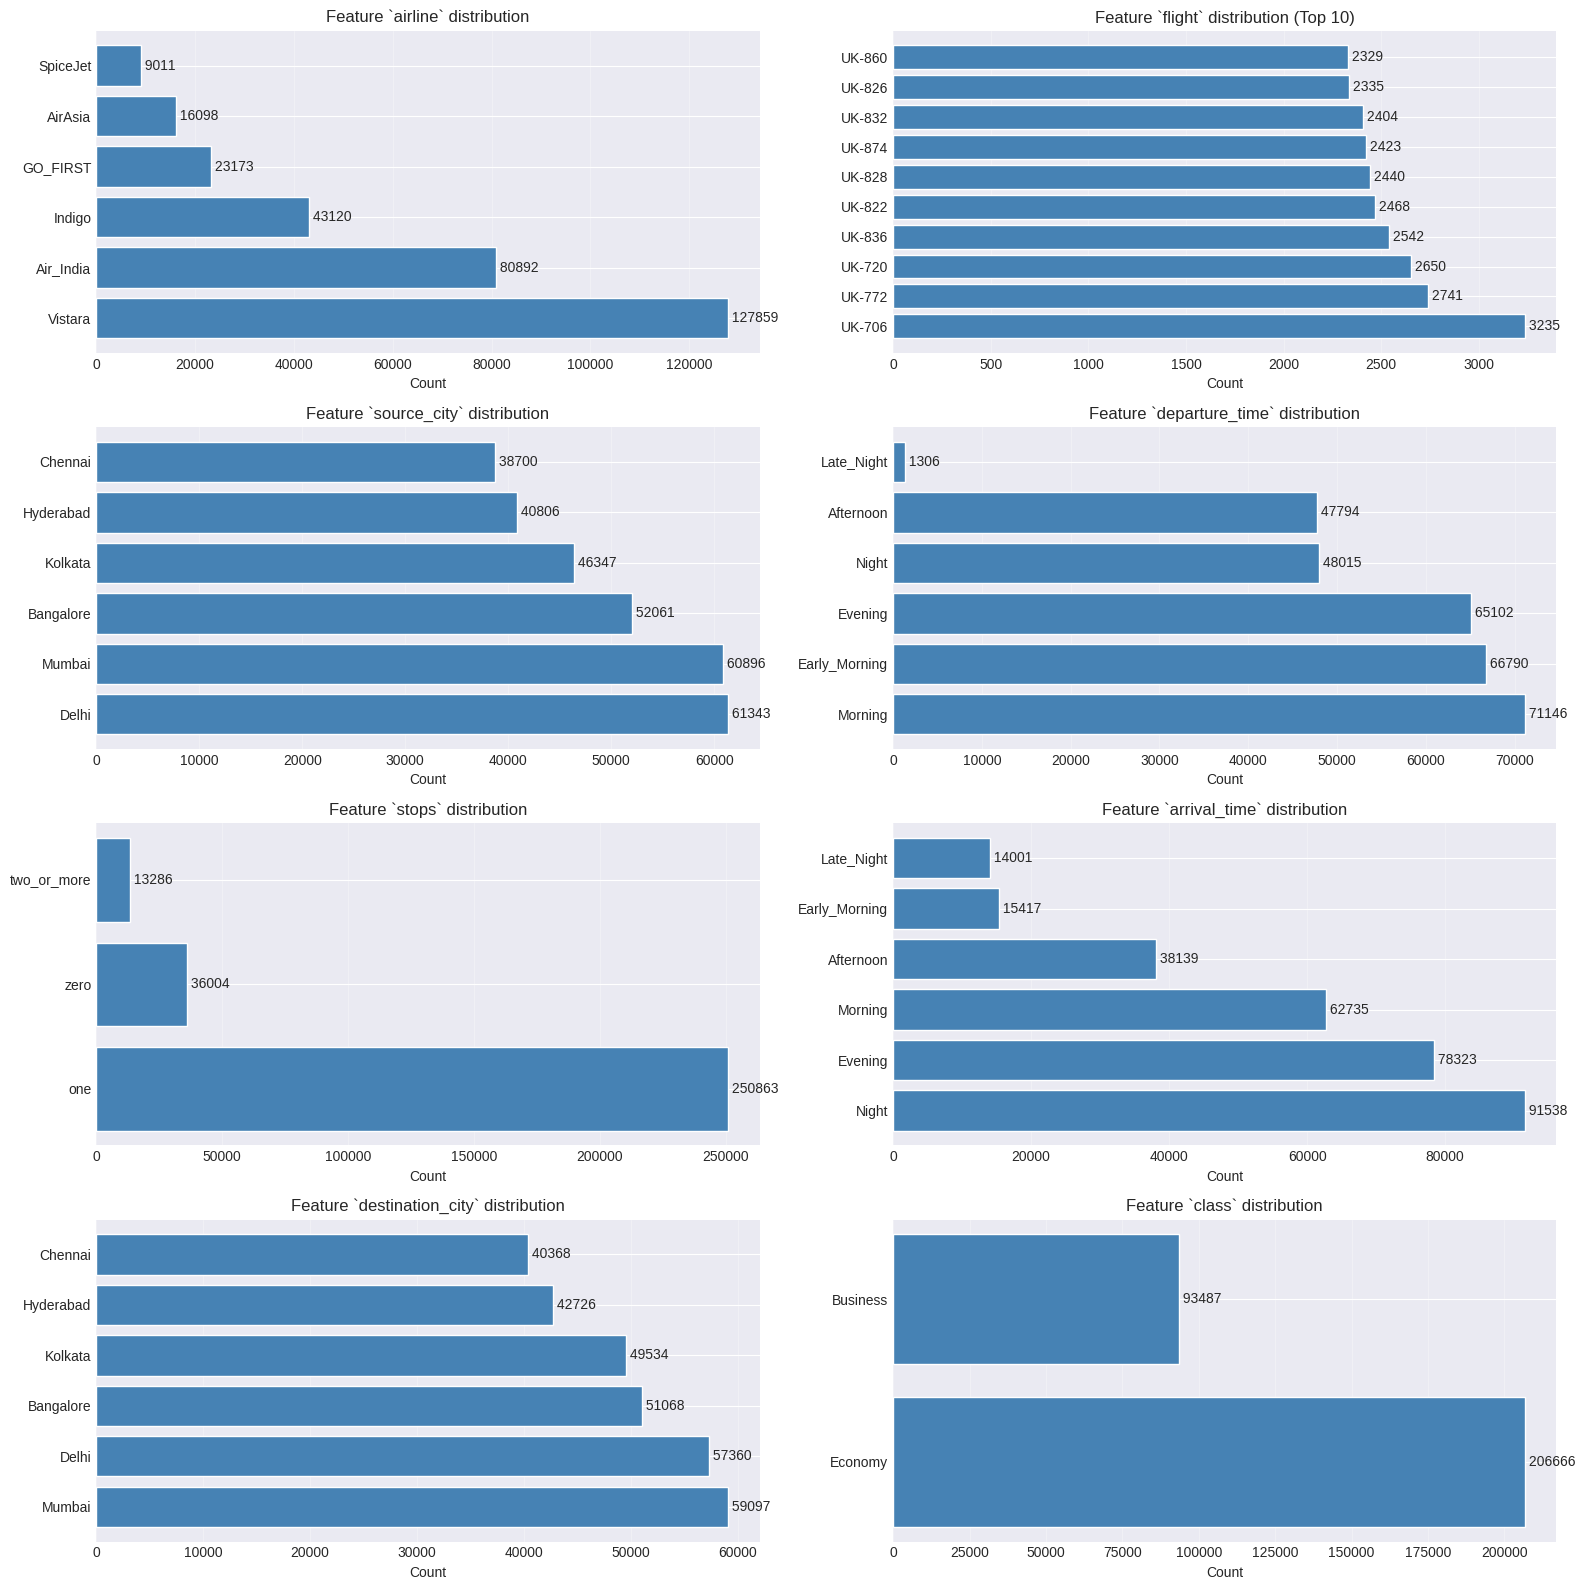

In [23]:
# Categorical features visualization

categorical_cols = clean_df.select_dtypes(include=['object']).columns.tolist()

# Determine number of categorical columns for subplot layout
n_cat = len(categorical_cols)
n_rows = (n_cat + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() if n_cat > 1 else [axes]

for idx, col in enumerate(categorical_cols):
    value_counts = clean_df[col].value_counts()
    title_suffix = ""

    # Limit to top 15 categories if too many
    if len(value_counts) > 10:
        value_counts = value_counts.head(10)
        title_suffix = " (Top 10)"

    axes[idx].barh(value_counts.index. astype(str), value_counts.values, color='steelblue')
    axes[idx].set_xlabel('Count')
    axes[idx].set_title(f'Feature `{col}` distribution{title_suffix}')
    axes[idx].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(value_counts.values):
        axes[idx].text(v, i, f' {v}', va='center')

# Remove empty subplots
for idx in range(n_cat, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## Dataset Issues Identification

In [24]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if 'Unnamed' not in col]

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

### Missing values

Check for null values.

In [25]:
# recap from "Dataset Structure and Attributes" stage
missing_data = pd.DataFrame({
    'Attribute': clean_df.columns,
    'Count': clean_df.count().values,
    'Missing Count': clean_df.isnull().sum().values,
})

print("Check for missing values")
print("="*80)
missing_data

Check for missing values


Attribute   Count  Missing Count
0         Unnamed: 0  300153              0
1            airline  300153              0
2             flight  300153              0
3        source_city  300153              0
4     departure_time  300153              0
5              stops  300153              0
6       arrival_time  300153              0
7   destination_city  300153              0
8              class  300153              0
9           duration  300153              0
10         days_left  300153              0
11             price  300153              0

### Outliers Detection

Finding unusual values in data.

In [26]:
print("Outliers Detection")
print("="*80)

def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_outliers = data[data[column] < lower_bound]
    upper_outliers = data[data[column] > upper_bound]
    outliers_count = len(lower_outliers) + len(upper_outliers)

    return {
        'column': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound':  lower_bound,
        'upper_bound': upper_bound,
        'lower_outliers_count': len(lower_outliers),
        'upper_outliers_count': len(upper_outliers),
        'outliers_count': outliers_count,
        'outlier_percentage': outliers_count / len(data) * 100
    }

outlier_summary = []


for col in numerical_cols:
    result = detect_outliers_iqr(clean_df, col)
    outlier_summary.append(result)

    if result['outliers_count'] > 0:
        print(f"\nColumn `{col}` outliers:")
        print(f"\tLower bound: {result['lower_bound']:.2f}")
        print(f"\t  Lower outliers: {result['lower_outliers_count']}")
        print(f"\tUpper bound: {result['upper_bound']:.2f}")
        print(f"\t  Upper outliers: {result['upper_outliers_count']}")
        # outlier_percentage < 5% is ok
        print(f"\tOutliers: {result['outliers_count']} ({result['outlier_percentage']:.2f}%)")

# outlier_df = pd.DataFrame(outlier_summary)
# print("\n" + "="*80)
# print("Outlier Summary:")
# outlier_df

Outliers Detection

Column `duration` outliers:
	Lower bound: -7.18
	  Lower outliers: 0
	Upper bound: 30.18
	  Upper outliers: 2110
	Outliers: 2110 (0.70%)

Column `price` outliers:
	Lower bound: -51824.00
	  Lower outliers: 0
	Upper bound: 99128.00
	  Upper outliers: 123
	Outliers: 123 (0.04%)


### Correlation Analysis

 Correlation analysis for numerical features
Highly Correlated Feature Pairs (|correlation| > 0.7):
	No highly correlated pairs found

Correlation Matrix:


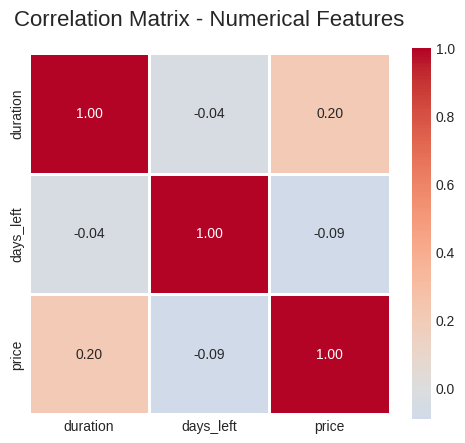

In [27]:
# Correlation Matrix

print(" Correlation analysis for numerical features")
print("="*80)

# Calculate correlation matrix
correlation_matrix = clean_df[numerical_cols].corr()



# Find highly correlated pairs
print("Highly Correlated Feature Pairs (|correlation| > 0.7):")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
else:
    print("\tNo highly correlated pairs found")



# Visualize correlation matrix
print("="*80)
print("\nCorrelation Matrix:")

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix - Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### Data Imbalance Check

Data Imbalance Check

Column `airline`:
  Total unique values: 6
  Most common:  Vistara (42.6%)
  Least common: SpiceJet (3.0%)
  Imbalance ratio: 14.19: 1


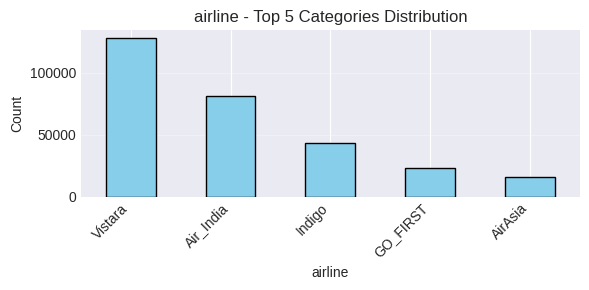

--------------------------------------------------------------------------------

Column `flight`:
  Total unique values: 1561
  Most common:  UK-706 (1.1%)
  Least common: SG-8339 (0.0%)
  Imbalance ratio: 3235.00: 1


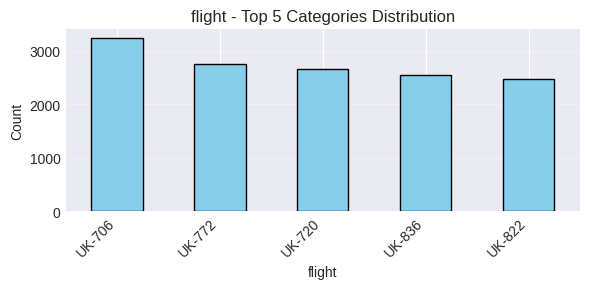

--------------------------------------------------------------------------------

Column `source_city`:
  Total unique values: 6
  Most common:  Delhi (20.4%)
  Least common: Chennai (12.9%)
  Imbalance ratio: 1.59: 1


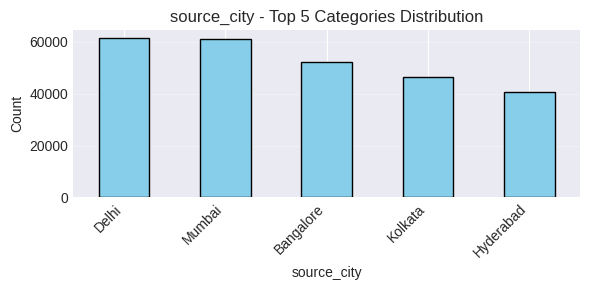

--------------------------------------------------------------------------------

Column `departure_time`:
  Total unique values: 6
  Most common:  Morning (23.7%)
  Least common: Late_Night (0.4%)
  Imbalance ratio: 54.48: 1


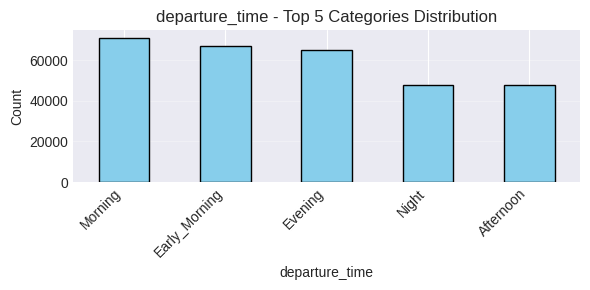

--------------------------------------------------------------------------------

Column `stops`:
  Total unique values: 3
  Most common:  one (83.6%)
  Least common: two_or_more (4.4%)
  Imbalance ratio: 18.88: 1


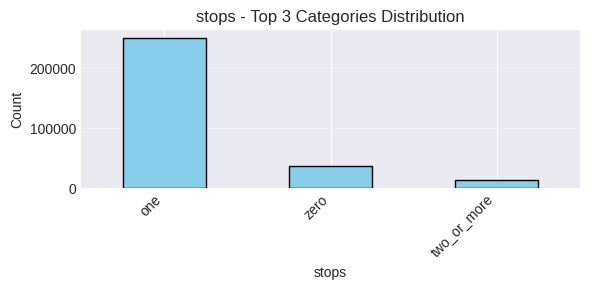

--------------------------------------------------------------------------------

Column `arrival_time`:
  Total unique values: 6
  Most common:  Night (30.5%)
  Least common: Late_Night (4.7%)
  Imbalance ratio: 6.54: 1


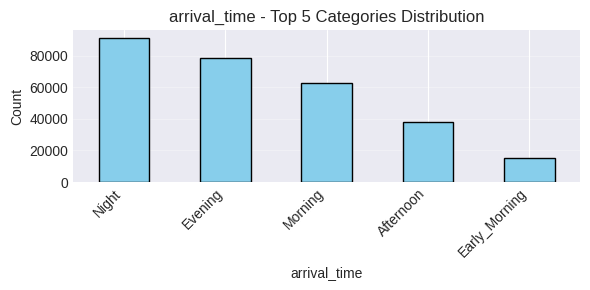

--------------------------------------------------------------------------------

Column `destination_city`:
  Total unique values: 6
  Most common:  Mumbai (19.7%)
  Least common: Chennai (13.4%)
  Imbalance ratio: 1.46: 1


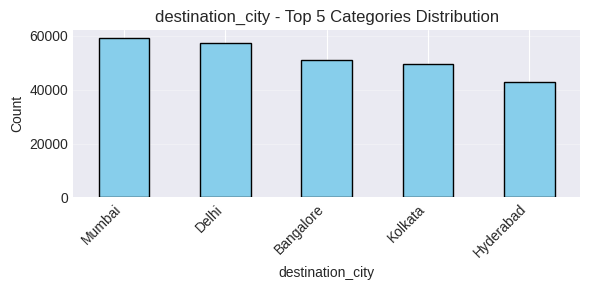

--------------------------------------------------------------------------------

Column `class`:
  Total unique values: 2
  Most common:  Economy (68.9%)
  Least common: Business (31.1%)
  Imbalance ratio: 2.21: 1
--------------------------------------------------------------------------------


In [28]:
# Check for imbalance in categorical features
print("Data Imbalance Check")
print("="*80)

for col in categorical_cols:
    value_counts = clean_df[col].value_counts()
    total = len(clean_df)

    print(f"\nColumn `{col}`:")
    print(f"  Total unique values: {len(value_counts)}")
    print(f"  Most common:  {value_counts.index[0]} ({value_counts.iloc[0]/total*100:.1f}%)")
    print(f"  Least common: {value_counts.index[-1]} ({value_counts.iloc[-1]/total*100:.1f}%)")
    print(f"  Imbalance ratio: {value_counts.iloc[0]/value_counts.iloc[-1]:.2f}: 1")

    # Visualize top categories
    if len(value_counts) > 2:
        top_n = min(5, len(value_counts))
        plt.figure(figsize=(6, 3))
        value_counts.head(top_n).plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'{col} - Top {top_n} Categories Distribution')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

    print("-"*80)

## Automated Data Profiling (ydata-profiling)

ydata_profiling is used to automatically generate an exploratory data analysis report for a dataset


In [29]:
print("Generating ydata-profiling report...")
print("="*80)

# Generate profile report
profile = ProfileReport(
    df,
    title="Flight Price Prediction - Data Profile Report",
    explorative=True
)

# Save to HTML
output_filename = "flight_price_data_profile.html"
profile. to_file(output_filename)

print(f"Report generated successfully: {output_filename}.")

Generating ydata-profiling report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Report generated successfully: flight_price_data_profile.html.


In [30]:
# view ydata-profiling report
profile.to_notebook_iframe()

## Data Preprocessing

In [31]:
print("="*80)
print("Data Preprocessing")
print("="*80)
print()

# 1. Load dataset
df = pd.read_csv('Clean_Dataset.csv')
print(f"Dataseet original columns: {list(df.columns)}.\n")

# 2. Remove unnecessary columns
# Remove unnamed column (just an index, not useful for prediction)
# Remove flight number - not useful for predictions, historical data.
columns_to_drop = [col for col in df.columns if col == 'flight' or 'Unnamed' in col]

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print(f"Removed columns: {columns_to_drop}.")
    print(f"Remaining columns: {list(df.columns)}.\n")

# 3. Separate target and features
# Target variable
y = df['price']
# Features (all columns except price)
X = df.drop('price', axis=1)

print(f"Target variable: price")
print(f"Features: {list(X.columns)} columns.\n")

# 4. Separate numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(numerical_features)}):")
for feature in numerical_features:
    print(f"  - {feature}")

print(f"Categorical features ({len(categorical_features)}):")
for feature in categorical_features:
    unique_count = X[feature].nunique()
    print(f"  - {feature}:  {unique_count} unique values")

# 5. Convert categorical data (text labels) into numeric form
# Random Forest requires numerical input.
# Use Label Encoding (converts text to numbers:  0, 1, 2, ... )
# This is suitable for Random Forest (tree-based models).
# Create a copy for encoding
X_encoded = X.copy()
# Dictionary to store label encoders (needed for new data later)
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    X_encoded[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

    print(f"\nEncoded '{feature}':")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for original, encoded in list(mapping.items())[:3]:  # Show first 3
        print(f"\t{original} -> {encoded}")
    if len(mapping) > 3:
        print(f"\t...  ({len(mapping)} total categories)")

print(f"\nAll categorical features encoded successfully.")
print(f"\nData types after encoding:")
print(X_encoded.dtypes)

# 6. Split dataset into training and testing subsets
# Split ratio:  80% training, 20% testing
print(f"\nSplit ratio: 80% training, 20% testing")
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42 # ensures reproducibility
)

print(f"\tTotal samples: {len(X_encoded)}")
print(f"\tTesting samples: {len(X_test)}")
print(f"\tTraining samples: {len(X_train)}")

Data Preprocessing

Dataseet original columns: ['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price'].

Removed columns: ['Unnamed: 0', 'flight'].
Remaining columns: ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price'].

Target variable: price
Features: ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left'] columns.


Numerical features (2):
  - duration
  - days_left
Categorical features (7):
  - airline:  6 unique values
  - source_city:  6 unique values
  - departure_time:  6 unique values
  - stops:  3 unique values
  - arrival_time:  6 unique values
  - destination_city:  6 unique values
  - class:  2 unique values

Encoded 'airline':
	AirAsia -> 0
	Air_India -> 1
	GO_FIRST -> 2
	...  (6 total categories)

Encoded 'source_city':
	Bang

## Random Forest Regression

### Model Training

Random Forest Regression has several important parameters that control how the model is built:

* **n_estimators**
This parameter defines the number of trees in the forest. A larger number usually improves performance, but it also increases training time. In practice, values between 100 and 300 are often used.

* **max_depth**
This parameter sets the maximum depth of each tree. Limiting the depth can prevent overfitting. If it is set to None, trees grow until all leaves are pure or contain a minimum number of samples.

* **min_samples_split**
This is the minimum number of samples required to split an internal node. Higher values make the tree more conservative and can reduce overfitting.

* **min_samples_leaf**
This parameter defines the minimum number of samples in a leaf node. It helps to smooth the predictions and reduce noise.

* **max_features**
This defines how many features are randomly selected at each split. For regression, a common choice is using all features or the square root of the number of features.

* **random_state**
This parameter is used to make the results reproducible. Setting it to a fixed number ensures that the same random choices are made each time the model is trained.


#### Baseline Model Training

In [95]:
# Create Random Forest model with default parameters
rf_baseline_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1, # -1 means use all CPU cores to train faster
    verbose=1
)

print("Random Forest model created with parameters:")
print(f"\t- n_estimators: {rf_baseline_model.n_estimators}")
print(f"\t- max_depth: {rf_baseline_model.max_depth} (unlimited)")
print(f"\t- min_samples_split: {rf_baseline_model.min_samples_split}")
print(f"\t- min_samples_leaf: {rf_baseline_model.min_samples_leaf}")
print(f"\t- max_features: {rf_baseline_model.max_features}")
print(f"\t- random_state: {rf_baseline_model.random_state}")

# Train the model
print("\nTraining baseline model started...")
print(f"Training on {len(X_train)} samples with {X_train.shape[1]} features.")

# LEARNING
rf_baseline_model.fit(X_train, y_train)

print("Training baseline model completed.")



# Predict
# Model is trained, now USING KNOWLEDGE

# Predict on training set
print("Predicting on training set...")
y_train_pred_baseline = rf_baseline_model.predict(X_train)

# Predict on testing set
print("Predicting on testing set...")
y_test_pred_baseline = rf_baseline_model.predict(X_test)

print("\nPredictions completed.")

print("\nSample predictions (first 5 test samples):")
comparison_df = pd.DataFrame({
    'Actual Price': y_test.iloc[:5].values,
    'Predicted Price': y_test_pred_baseline[:5],
    'Difference': y_test.iloc[:5].values - y_test_pred_baseline[:5]
})
print(comparison_df.to_string(index=False))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Random Forest model created with parameters:
	- n_estimators: 100
	- max_depth: None (unlimited)
	- min_samples_split: 2
	- min_samples_leaf: 1
	- max_features: sqrt
	- random_state: 42

Training baseline model started...
Training on 240122 samples with 9 features.


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training baseline model completed.
Predicting on training set...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Predicting on testing set...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s



Predictions completed.

Sample predictions (first 5 test samples):
 Actual Price  Predicted Price  Difference
         7366          6505.26      860.74
        64831         71236.52    -6405.52
         6195          6183.26       11.74
        60160         60302.29     -142.29
         6578          6245.67      332.33


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished


#### Tuned Model Training

In [94]:
# Create Random Forest model with default parameters
rf_tuned_model = RandomForestRegressor(
    n_estimators=200,       # More trees (better predictions, slower)
    max_depth=None,           # Limit depth (prevents overfitting)
    min_samples_split=5,    # More samples to split (prevents overfitting)
    min_samples_leaf=2,     # Min samples in leaves (smoother predictions)
    max_features=0.5,
    random_state=42,
    n_jobs=-1, # -1 means use all CPU cores to train faster
    verbose=1
)

print("Random Forest model created with parameters:")
print(f"\t- n_estimators: {rf_tuned_model.n_estimators}")
print(f"\t- max_depth: {rf_tuned_model.max_depth} (unlimited)")
print(f"\t- min_samples_split: {rf_tuned_model.min_samples_split}")
print(f"\t- min_samples_leaf: {rf_tuned_model.min_samples_leaf}")
print(f"\t- max_features: {rf_tuned_model.max_features}")
print(f"\t- random_state: {rf_tuned_model.random_state}")

# Train the model
print("\nTraining tuned model started...")
print(f"Training on {len(X_train)} samples with {X_train.shape[1]} features.")

# LEARNING
rf_tuned_model.fit(X_train, y_train)

print("Training tuned model completed.")


# Predict
# Model is trained, now USING KNOWLEDGE

# Predict on training set
print("Predicting on training set...")
y_train_pred_tuned = rf_tuned_model.predict(X_train)

# Predict on testing set
print("Predicting on testing set...")
y_test_pred_tuned = rf_tuned_model.predict(X_test)

print("\nPredictions completed.")

print("\nSample predictions (first 5 test samples):")
comparison_df = pd.DataFrame({
    'Actual Price': y_test.iloc[:5].values,
    'Predicted Price': y_test_pred_tuned[:5],
    'Difference': y_test.iloc[:5].values - y_test_pred_tuned[:5]
})
print(comparison_df.to_string(index=False))

Random Forest model created with parameters:
	- n_estimators: 200
	- max_depth: None (unlimited)
	- min_samples_split: 5
	- min_samples_leaf: 2
	- max_features: 0.5
	- random_state: 42

Training tuned model started...
Training on 240122 samples with 9 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training tuned model completed.
Predicting on training set...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   14.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Predicting on testing set...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s



Predictions completed.

Sample predictions (first 5 test samples):
 Actual Price  Predicted Price  Difference
         7366          6275.28     1090.72
        64831         68316.38    -3485.38
         6195          6205.24      -10.24
        60160         61407.19    -1247.19
         6578          6301.43      276.57


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    5.1s finished


#### Compare baseline vs. tuned models

In [159]:
# Calculate metrics for both models

def adjusted_r2_score(y_true, y_pred, n_features):
    """
    Calculate Adjusted R² Score

    Formula: Adjusted R² = 1 - [(1 - R²) * (n - 1) / (n - k - 1)]
    where:
        n = number of samples
        k = number of features
    """
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    k = n_features

    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return adjusted_r2


def is_tuned_win(baseline_metrics, tuned_metrics, is_tuned_better, metric_name):
    difference = tuned_metrics[metric_name] - baseline_metrics[metric_name]
    is_same = difference == 0

    is_tuned_winner = False
    if is_same:
        print(f"Baseline and tuned models are same.")
    if is_tuned_better:
        is_tuned_winner = True
        print(f"✅ Tuned model is better!")
    else:
        print(f"❌ Baseline model is better!")

    print(f"\tBaseline: {baseline_metrics[metric_name]:.4f}")
    print(f"\tTuned:     {tuned_metrics[metric_name]:.4f}")
    print(f"\tDifference: {difference:.4f}")
    return is_tuned_winner

n_features = X_train.shape[1]

baseline_metrics = {
    # Training metrics
    'train_mse': mean_squared_error(y_train, y_train_pred_baseline),
    'train_mae': mean_absolute_error(y_train, y_train_pred_baseline),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_baseline)),
    'train_r2':  r2_score(y_train, y_train_pred_baseline),
    'train_adj_r2': adjusted_r2_score(y_train, y_train_pred_baseline, n_features),

    # Testing metrics
    'test_mse': mean_squared_error(y_test, y_test_pred_baseline),
    'test_mae': mean_absolute_error(y_test, y_test_pred_baseline),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_baseline)),
    'test_r2': r2_score(y_test, y_test_pred_baseline),
    'test_adj_r2': adjusted_r2_score(y_test, y_test_pred_baseline, n_features),
}

tuned_metrics = {
    # Training metrics
    'train_mse': mean_squared_error(y_train, y_train_pred_tuned),
    'train_mae': mean_absolute_error(y_train, y_train_pred_tuned),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_tuned)),
    'train_r2': r2_score(y_train, y_train_pred_tuned),
    'train_adj_r2': adjusted_r2_score(y_train, y_train_pred_tuned, n_features),

    # Testing metrics
    'test_mse': mean_squared_error(y_test, y_test_pred_tuned),
    'test_mae': mean_absolute_error(y_test, y_test_pred_tuned),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_tuned)),
    'test_r2': r2_score(y_test, y_test_pred_tuned),
    'test_adj_r2': adjusted_r2_score(y_test, y_test_pred_tuned, n_features),
}


print("Baseline VS. tuned model compraison")

print("\nTraining set performance:")
print("="*80)

train_comparison = pd.DataFrame({
    'Metric': ['MSE (₹²)', 'MAE (₹)', 'RMSE (₹)', 'R²', 'Adjusted R²'],
    'Baseline': [
        f'{baseline_metrics["train_mse"]:,.2f}',
        f'{baseline_metrics["train_mae"]:,.2f}',
        f'{baseline_metrics["train_rmse"]:,.2f}',
        f'{baseline_metrics["train_r2"]:.4f}',
        f'{baseline_metrics["train_adj_r2"]:.4f}'
    ],
    'Tuned':  [
        f'{tuned_metrics["train_mse"]:,.2f}',
        f'{tuned_metrics["train_mae"]:,.2f}',
        f'{tuned_metrics["train_rmse"]:,.2f}',
        f'{tuned_metrics["train_r2"]:.4f}',
        f'{tuned_metrics["train_adj_r2"]:.4f}'
    ],
    'Difference': [
        f'{tuned_metrics["train_mse"] - baseline_metrics["train_mse"]:,.2f}',
        f'{tuned_metrics["train_mae"] - baseline_metrics["train_mae"]:,.2f}',
        f'{tuned_metrics["train_rmse"] - baseline_metrics["train_rmse"]:,.2f}',
        f'{tuned_metrics["train_r2"] - baseline_metrics["train_r2"]:+.4f}',
        f'{tuned_metrics["train_adj_r2"] - baseline_metrics["train_adj_r2"]:+.4f}'
    ]
})

print(train_comparison.to_string(index=False))

print("\n!!! Testing set performance:")
print("="*80)

test_comparison = pd.DataFrame({
    'Metric': ['MSE (₹²)', 'MAE (₹)', 'RMSE (₹)', 'R²', 'Adjusted R²'],
    'Baseline': [
        f'{baseline_metrics["test_mse"]:,.2f}',
        f'{baseline_metrics["test_mae"]:,.2f}',
        f'{baseline_metrics["test_rmse"]: ,.2f}',
        f'{baseline_metrics["test_r2"]:.4f}',
        f'{baseline_metrics["test_adj_r2"]:.4f}'
    ],
    'Tuned': [
        f'{tuned_metrics["test_mse"]:,.2f}',
        f'{tuned_metrics["test_mae"]:,.2f}',
        f'{tuned_metrics["test_rmse"]:,.2f}',
        f'{tuned_metrics["test_r2"]:.4f}',
        f'{tuned_metrics["test_adj_r2"]:.4f}'
    ],
    'Difference':  [
        f'{tuned_metrics["test_mse"] - baseline_metrics["test_mse"]:,.2f}',
        f'{tuned_metrics["test_mae"] - baseline_metrics["test_mae"]:,.2f}',
        f'{tuned_metrics["test_rmse"] - baseline_metrics["test_rmse"]:,.2f}',
        f'{tuned_metrics["test_r2"] - baseline_metrics["test_r2"]:+.4f}',
        f'{tuned_metrics["test_adj_r2"] - baseline_metrics["test_adj_r2"]:+.4f}'
    ]
})

print(test_comparison.to_string(index=False))

print("\n" + "="*80)
print("Which model is better?")
print("="*80)

# Compare on testing metrics
r2_improved = tuned_metrics['test_r2'] > baseline_metrics['test_r2']
mae_improved = tuned_metrics['test_mae'] < baseline_metrics['test_mae']
rmse_improved = tuned_metrics['test_rmse'] < baseline_metrics['test_rmse']
adj_r2_improved = tuned_metrics['test_adj_r2'] > baseline_metrics['test_adj_r2']

tuned_wins = 0

print("\nR² Score:")
if (is_tuned_win(baseline_metrics, tuned_metrics, r2_improved, 'test_r2')):
    tuned_wins += 1

print("\nMAE (Mean Absolute Error):")
if (is_tuned_win(baseline_metrics, tuned_metrics, mae_improved, 'test_mae')):
    tuned_wins += 1

print("\nRMSE (Root Mean Squared Error):")
if (is_tuned_win(baseline_metrics, tuned_metrics, mae_improved, 'test_rmse')):
    tuned_wins += 1

print("\nAdjusted R²:")
if (is_tuned_win(baseline_metrics, tuned_metrics, mae_improved, 'test_adj_r2')):
    tuned_wins += 1

if tuned_wins >= 3:
  winner = "Tuned"
else:
  winner = "Baseline"

print()
if tuned_wins != 2:
  print(f"{winner} model improved on {tuned_wins}/4 metrics")

print("\n" + "="*80)
print(f"WINNER: {winner} model")
print("="*80)

Baseline VS. tuned model compraison

Training set performance:
     Metric     Baseline        Tuned   Difference
   MSE (₹²) 1,351,522.43 3,496,748.22 2,145,225.79
    MAE (₹)       474.21       810.81       336.61
   RMSE (₹)     1,162.55     1,869.96       707.41
         R²       0.9974       0.9932      -0.0042
Adjusted R²       0.9974       0.9932      -0.0042

!!! Testing set performance:
     Metric     Baseline        Tuned  Difference
   MSE (₹²) 8,177,456.43 7,441,302.56 -736,153.87
    MAE (₹)     1,221.10     1,201.68      -19.42
   RMSE (₹)     2,859.63     2,727.88     -131.75
         R²       0.9841       0.9856     +0.0014
Adjusted R²       0.9841       0.9856     +0.0014

Which model is better?

R² Score:
✅ Tuned model is better!
	Baseline: 0.9841
	Tuned:     0.9856
	Difference: 0.0014

MAE (Mean Absolute Error):
✅ Tuned model is better!
	Baseline: 1221.1018
	Tuned:     1201.6781
	Difference: -19.4238

RMSE (Root Mean Squared Error):
✅ Tuned model is better!
	Baselin

### Evaluate Model Performance

In [160]:
rf_model = rf_tuned_model
y_train_pred = y_train_pred_tuned
y_test_pred = y_test_pred_tuned

In [161]:
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    Calculate Adjusted R² Score

    Formula: Adjusted R² = 1 - [(1 - R²) * (n - 1) / (n - k - 1)]
    where:
        n = number of samples
        k = number of features
    """
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    k = n_features

    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return adjusted_r2

# Number of features
n_features = X_train.shape[1]

# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_adj_r2 = adjusted_r2_score(y_train, y_train_pred, n_features)

# Calculate metrics for testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = adjusted_r2_score(y_test, y_test_pred, n_features)

print("\nTraining set performance:")
print(f"\tMean Squared Error (MSE):       ₹{train_mse:,.2f}")
print(f"\tMean Absolute Error (MAE):      ₹{train_mae:,.2f}")
print(f"\tRoot Mean Squared Error (RMSE): ₹{train_rmse:,.2f}")
print(f"\tR² Score (R-squared):            {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"\tAdjusted R² Score:               {train_adj_r2:.4f} ({train_adj_r2*100:.2f}%)")

print("\nTesting set performance:")
print(f"Mean Squared Error (MSE):       ₹{test_mse:,.2f}")
print(f"Mean Absolute Error (MAE):      ₹{test_mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ₹{test_rmse:,.2f}")
print(f"R² Score (R-squared):            {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"Adjusted R² Score:               {test_adj_r2:.4f} ({test_adj_r2*100:.2f}%)")

# WHAT DO THESE METRICS MEAN???

# MSE (Mean Squared Error)
#   Average of squared errors (penalizes large errors heavily)
#   Lower is better (0 = perfect)

# RMSE (Root Mean Squared Error)
#   Square root of MSE (same units as price)
#   Lower is better (0 = perfect)

# MAE (Mean Absolute Error)
#   On average, predictions are off by ₹ test_mae
#   Less sensitive to outliers than RMSE
#   Lower is better (0 = perfect)

# R² Score (Coefficient of Determination)
#   Model explains {test_r2*100:.1f}% of price variation"
#   Closer to 1.0 is better

# Adjusted R² Score:
#   R² adjusted for number of features
#   Penalizes adding unnecessary features
#   More reliable than R² for model comparison

print("\nR² Score interpretation:")
if test_r2 >= 0.9:
    print("\tExcellent!  (90%+)")
elif test_r2 >= 0.8:
    print("\tVery Good! (80-90%)")
elif test_r2 >= 0.7:
    print("\tGood (70-80%)")
elif test_r2 >= 0.6:
    print("\tAcceptable (60-70%)")
else:
    print("\tNeeds improvement (<60%)")

# Calculate average price for context
# When you see an error like: MAE = ₹2,500
# Question: Is this good or bad?
# You can't tell! It depends on the price range!
# MAE:  ₹2,500
#   Average price: ₹5,000
#   - ₹2,500 error on a ₹5,000 flight
#   - That's 50% error!
#   - Very bad!  Half the price wrong!
#   Average price: ₹50,000
#   - ₹2,500 error on a ₹50,000 flight
#   - That's only 5% error!
#   - Pretty good! Close to actual price!
avg_price = y_test.mean()
mae_percentage = (test_mae / avg_price) * 100

print(f"\nAverage flight price: ₹{avg_price:,.0f}")
print(f"MAE:  ₹{test_mae:,.2f}")
print(f"MAE as percentage of average price: {mae_percentage:.2f}%")

# Check for overfitting
print("\nOverfitting check:")
if train_r2 - test_r2 < 0.05:
    print("\tNo significant overfitting detected")
elif train_r2 - test_r2 < 0.10:
    print("\tSlight overfitting (acceptable)")
else:
    print("\tOverfitting detected! Training performance much better than testing")


Training set performance:
	Mean Squared Error (MSE):       ₹3,496,748.22
	Mean Absolute Error (MAE):      ₹810.81
	Root Mean Squared Error (RMSE): ₹1,869.96
	R² Score (R-squared):            0.9932 (99.32%)
	Adjusted R² Score:               0.9932 (99.32%)

Testing set performance:
Mean Squared Error (MSE):       ₹7,441,302.56
Mean Absolute Error (MAE):      ₹1,201.68
Root Mean Squared Error (RMSE): ₹2,727.88
R² Score (R-squared):            0.9856 (98.56%)
Adjusted R² Score:               0.9856 (98.56%)

R² Score interpretation:
	Excellent!  (90%+)

Average flight price: ₹20,894
MAE:  ₹1,201.68
MAE as percentage of average price: 5.75%

Overfitting check:
	No significant overfitting detected


### Feature Importance Analysis

In [165]:
feature_importance = pd. DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature importance ranking:")
print("="*80)
print(feature_importance.to_string(index=False))

print("\nMost important features for predicting price:")
for idx, row in feature_importance.iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")


Feature importance ranking:
         Feature  Importance
           class        0.82
         airline        0.06
        duration        0.05
           stops        0.02
       days_left        0.02
     source_city        0.01
destination_city        0.01
    arrival_time        0.00
  departure_time        0.00

Most important features for predicting price:
  7. class: 0.8238 (82.38%)
  1. airline: 0.0631 (6.31%)
  8. duration: 0.0514 (5.14%)
  4. stops: 0.0171 (1.71%)
  9. days_left: 0.0166 (1.66%)
  2. source_city: 0.0097 (0.97%)
  6. destination_city: 0.0096 (0.96%)
  5. arrival_time: 0.0047 (0.47%)
  3. departure_time: 0.0040 (0.40%)


### Visualization: Actual VS. Predicted

Text(0.05, 0.95, 'R² = 0.9856\nMAE = ₹1,202\nRMSE = ₹2,728')

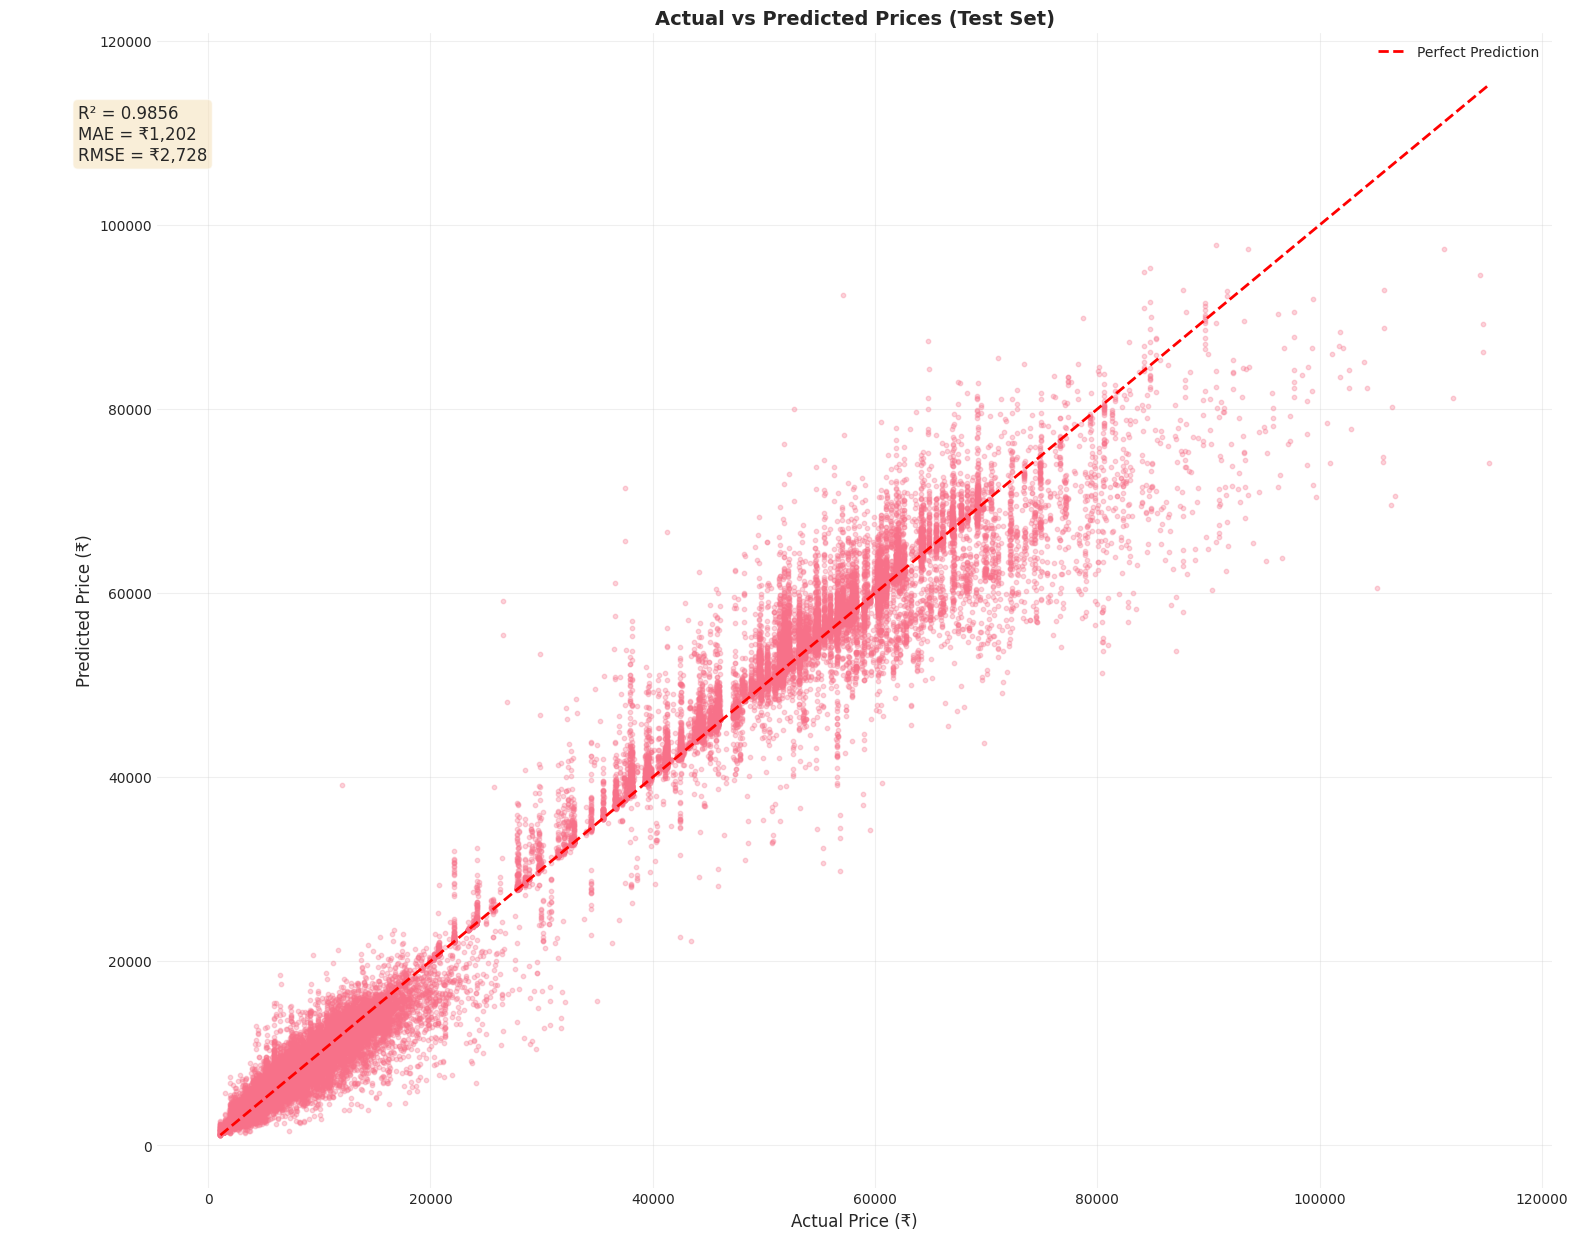

In [143]:
fig, ax = plt.subplots()

ax.scatter(y_test, y_test_pred, alpha=0.3, s=10)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Perfect Prediction')
ax. set_xlabel('Actual Price (₹)', fontsize=12)
ax.set_ylabel('Predicted Price (₹)', fontsize=12)
ax.set_title('Actual vs Predicted Prices (Test Set)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add R² score to plot
textstr = f'R² = {test_r2:.4f}\nMAE = ₹{test_mae:,.0f}\nRMSE = ₹{test_rmse:,.0f}'
ax.text(0.05, 0.95, textstr,
                transform=axes[0, 0].transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

### Visualization: Distribution of Prediction Errors

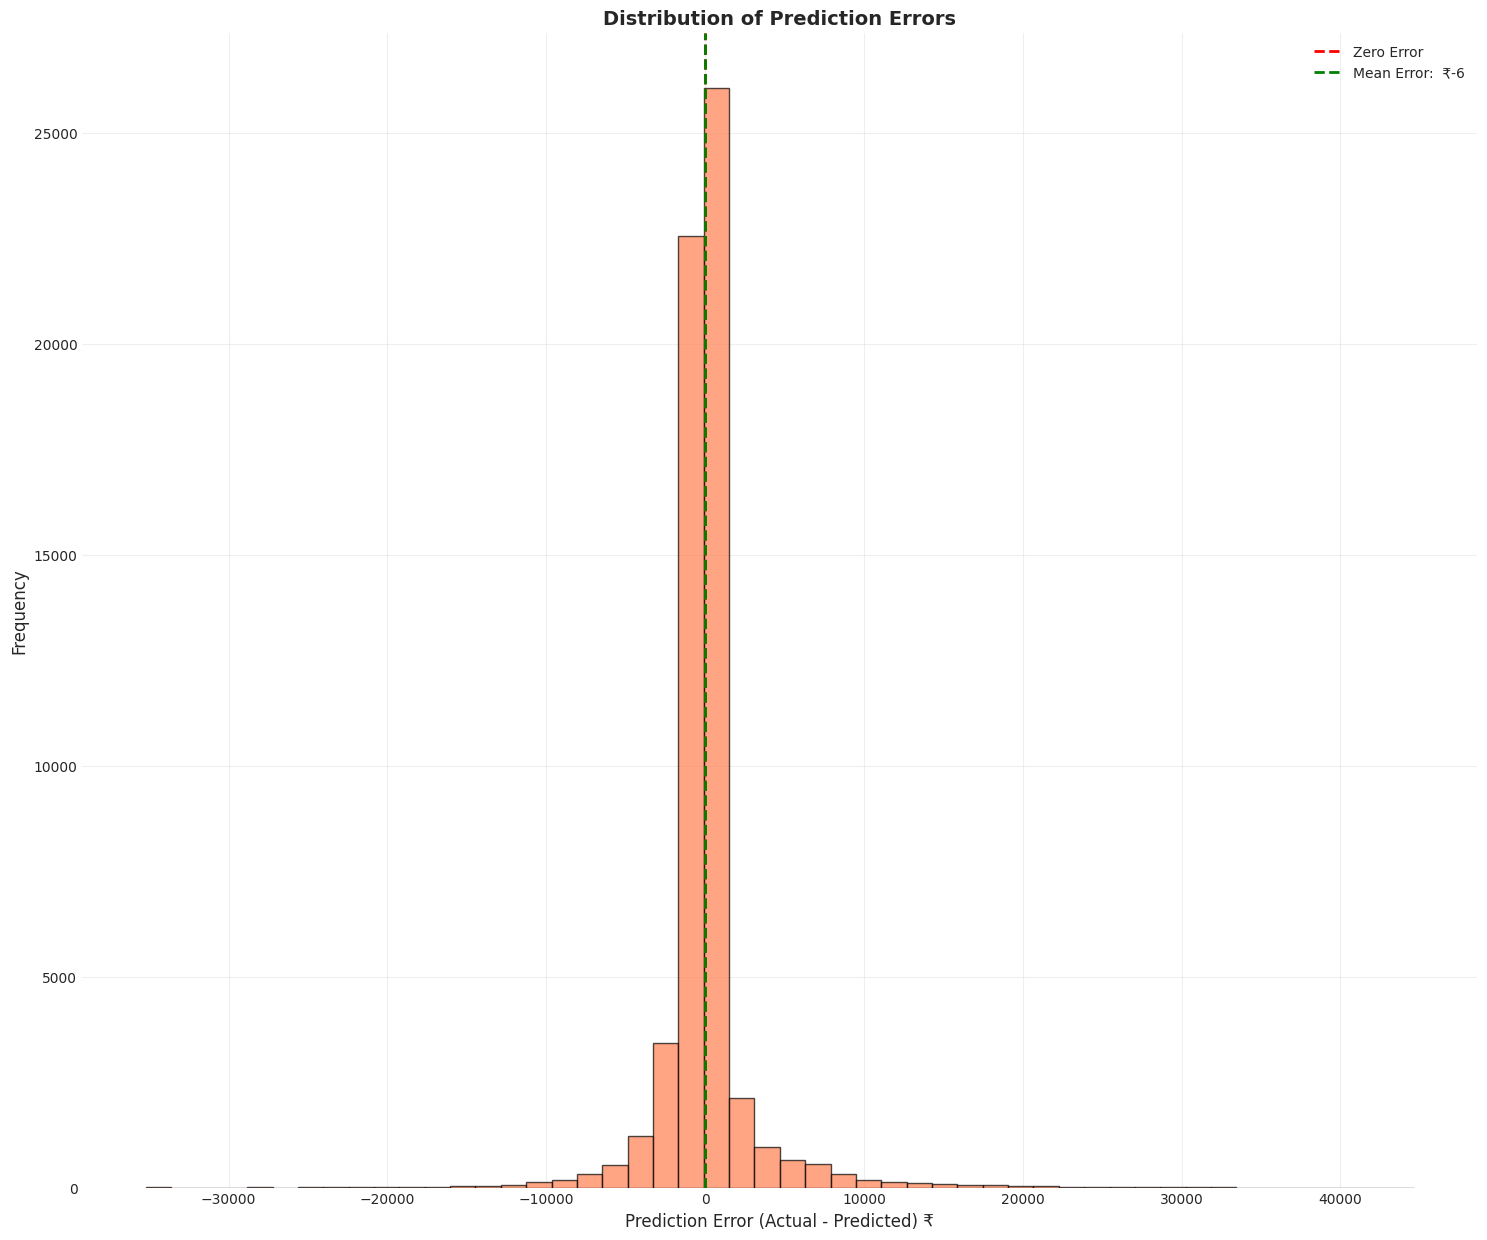

In [151]:
fig, ax = plt.subplots()

errors = y_test - y_test_pred
ax. hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.axvline(errors.mean(), color='green', linestyle='--', linewidth=2,
           label=f'Mean Error:  ₹{errors.mean():,.0f}')
ax.set_xlabel('Prediction Error (Actual - Predicted) ₹', fontsize=12)
ax. set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# That tall bar in the middle at 0 means taht most of predictions have SMALL errors

### Visualization: Residual Plot

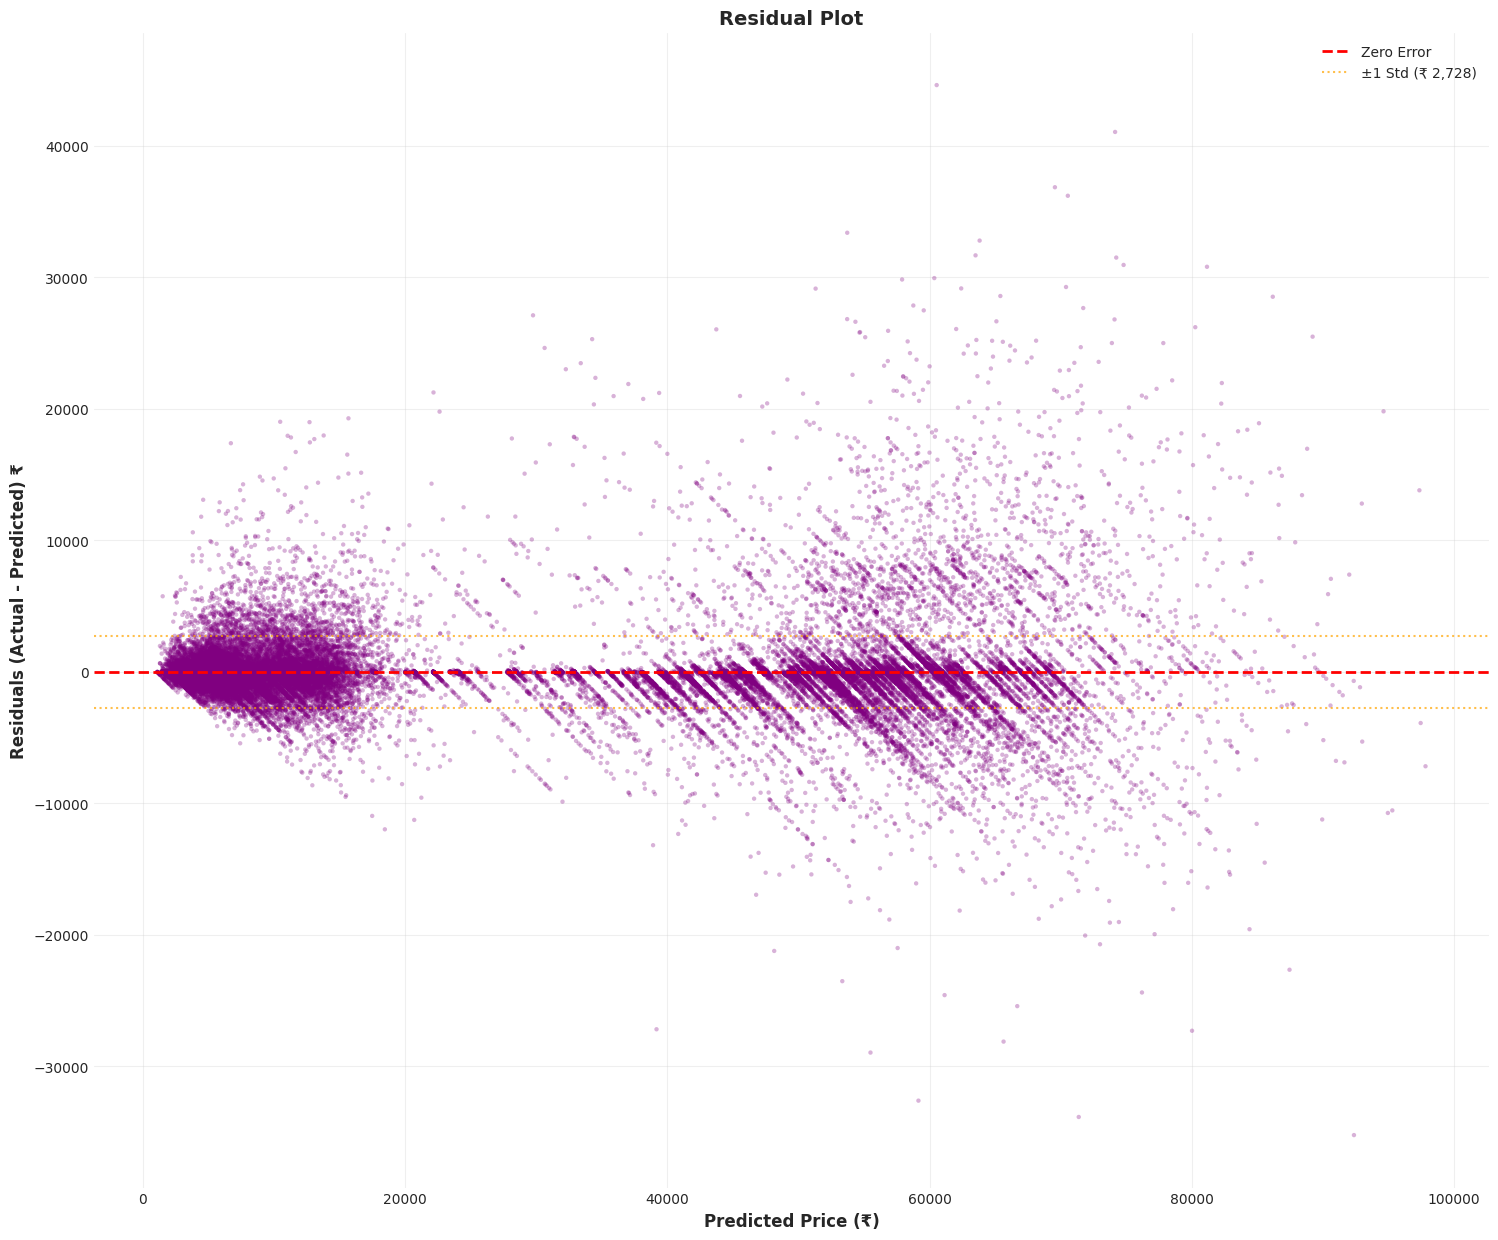

In [163]:
fig, ax = plt.subplots()

residuals = y_test - y_test_pred

ax.scatter(y_test_pred, residuals, alpha=0.3, s=10, color='purple', edgecolors='none')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error', zorder=5)

# Add horizontal lines for +/- 1 std
std_residual = residuals.std()
ax.axhline(y=std_residual, color='orange', linestyle=':', linewidth=1.5,
            label=f'±1 Std (₹{std_residual: ,.0f})', alpha=0.7)
ax.axhline(y=-std_residual, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Predicted Price (₹)', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals (Actual - Predicted) ₹', fontsize=12, fontweight='bold')
ax.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Diagonal stripes on the plot are typical for random forst

#### Visualization: Learning Curves

[learning_curve] Training set sizes: [ 16008  48024  96048 160081]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:  2.8min remaining:  2.8min
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.4min finished


Learning curves calculated!
Creating learning curves plot...


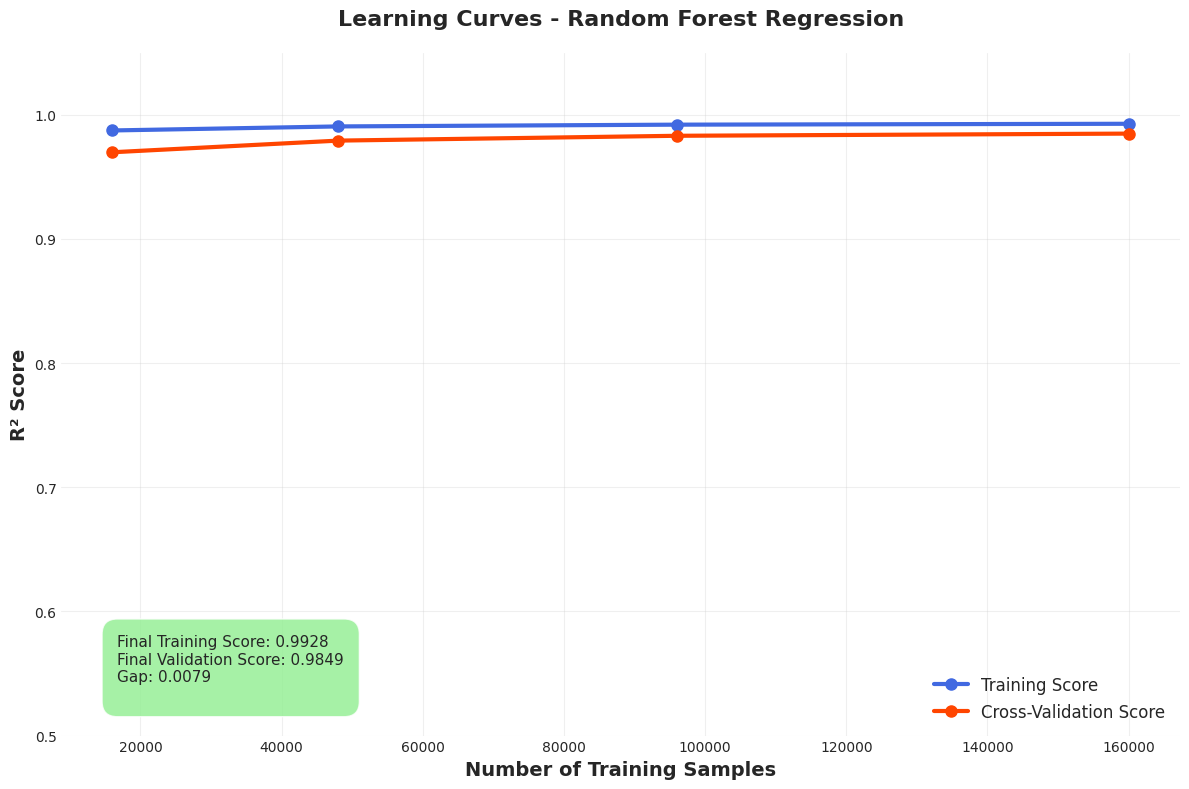

In [164]:
# Learning curves show: "Does my model get better when I give it more training data?"

# Blue Line = Training Score
# "How well does the model perform on data it STUDIED from?"
# Orange Line = Cross-Validation Score
# "How well does the model perform on data it NEVER saw before?"

print("WARNING: This will take a lot of time!")

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X_train,
    y_train,
    cv=3,  # Reduced from 5 to 3 to make visualization faster
    n_jobs=-1,
    train_sizes=[0.1, 0.3, 0.6, 1.0],  # Only 4 points - to make vistualization generation faster
    scoring='r2',
    verbose=2,  # Show progress
    random_state=42
)


print(f"Learning curves calculated!")

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np. std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# ----------------------------------------------------------------------------
# PLOT LEARNING CURVES
# ----------------------------------------------------------------------------

print("Creating learning curves plot...")

fig, ax = plt.subplots(figsize=(12, 8))

# Plot training scores
ax.plot(train_sizes, train_scores_mean, 'o-', color='royalblue',
        label='Training Score', linewidth=3, markersize=8)
ax.fill_between(train_sizes,
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.2, color='royalblue')

# Plot validation scores
ax. plot(train_sizes, val_scores_mean, 'o-', color='orangered',
        label='Cross-Validation Score', linewidth=3, markersize=8)
ax.fill_between(train_sizes,
                val_scores_mean - val_scores_std,
                val_scores_mean + val_scores_std,
                alpha=0.2, color='orangered')

ax.set_xlabel('Number of Training Samples', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=14, fontweight='bold')
ax.set_title('Learning Curves - Random Forest Regression',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.05])

# Add interpretation
final_gap = train_scores_mean[-1] - val_scores_mean[-1]
final_val_score = val_scores_mean[-1]

interpretation_lines = []
interpretation_lines.append(f"Final Training Score: {train_scores_mean[-1]:.4f}")
interpretation_lines.append(f"Final Validation Score: {val_scores_mean[-1]:.4f}")
interpretation_lines.append(f"Gap: {final_gap:.4f}")
interpretation_lines.append("")

interpretation_text = "\n".join(interpretation_lines)

ax.text(0.05, 0.05, interpretation_text,
        transform=ax.transAxes,
        fontsize=11, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor=color_box, alpha=0.8, pad=1))

plt.tight_layout()
plt.show()